In [1]:
# SECTION 1: SETUP & IMPORTS

# Core ML
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import nibabel as nib
import matplotlib.pyplot as plt
import torchio as tio
import warnings
import torchvision.transforms as transforms



# System and Warnings
import warnings
warnings.filterwarnings("ignore")

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# Configurations
IMG_SIZE = 128
VOLUME_SLICES = 50
VOLUME_START_AT = 22
BATCH_SIZE = 1
NUM_EPOCHS = 5
NUM_ROUNDS = 2
batch_size = 1  # stable
pin_memory = True
num_workers = 4  # or os.cpu_count() // 2



In [3]:
# CELL 2: BraTSDataset Loader

class BraTSDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.patient_dirs = sorted(os.listdir(root_dir))
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_id = self.patient_dirs[idx]
        patient_path = os.path.join(self.root_dir, patient_id)

        # Load MRI modalities
        modalities = ['t1c', 't1n', 't2f', 't2w']
        image_data = []
        for mod in modalities:
            image_path = os.path.join(patient_path, f"{patient_id}-{mod}.nii")
            image = nib.load(image_path).get_fdata()
            image_data.append(image)

        image_np = np.stack(image_data, axis=0).astype(np.float32)
        image_tensor = torch.tensor(image_np)

        # Load segmentation label if in training mode
        if self.train:
            label_path = os.path.join(patient_path, f"{patient_id}-seg.nii")
            label_np = nib.load(label_path).get_fdata().astype(np.uint8)
            label_tensor = torch.tensor(label_np).unsqueeze(0)
        else:
            label_tensor = None  # inference only

        # Apply TorchIO preprocessing
        if self.transform:
            subject_dict = {"images": tio.ScalarImage(tensor=image_tensor)}
            if label_tensor is not None:
                subject_dict["label"] = tio.LabelMap(tensor=label_tensor)
            subject = tio.Subject(**subject_dict)
            transformed = self.transform(subject)
            image_tensor = transformed.images.data
            if label_tensor is not None:
                label_tensor = transformed.label.data

        return (image_tensor, label_tensor) if self.train else image_tensor


In [4]:
# CELL 3: TorchIO Preprocessing Transform

transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),  # Normalize intensities to [0, 1]
    tio.Resize((128, 128, 128)),               # Resize to fixed shape
    tio.ZNormalization()                       # Normalize mean=0, std=1
])


In [5]:
augment_transform = tio.Compose([
    # Intensity-based
    tio.RandomBiasField(p=0.3),
    tio.RandomGamma(p=0.3),
    tio.RandomNoise(p=0.2),
    
    # Spatial-based
    tio.RandomAffine(
        scales=(0.9, 1.1),
        degrees=10,
        translation=5,
        center='image',
        p=0.5
    ),
    tio.RandomElasticDeformation(p=0.2),
    tio.RandomFlip(axes=('LR',), p=0.5),

    # Preprocessing
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.Resize((128, 128, 128)),
    tio.ZNormalization()
])


In [6]:
# CELL 4: Client Dataset Paths and Loaders

# Define paths (adjust as needed to match your directory structure)
Hospital1_Train = 'Data/2023GLI/TrainingData'
Hospital1_Val   = 'Data/2023GLI/ValidationData'
Hospital2_Train = 'Data/2023MEN/TrainingData'
Hospital2_Val   = 'Data/2023MEN/ValidationData'
Hospital3_Train = 'Data/2023MET/TrainingData'
Hospital3_Val   = 'Data/2023MET/ValidationData'
Hospital4_Train = 'Data/2023PED/TrainingData'
Hospital4_Val   = 'Data/2023PED/ValidationData'
Hospital5_Train = 'Data/2023SSA/TrainingData'
Hospital5_Val   = 'Data/2023SSA/ValidationData'
Hospital6_Train_Val = 'Data/BraTS2021'
Hospital7_Train = 'Data/BraTS2020/TrainingData'
Hospital7_Val   = 'Data/BraTS2020/ValidationData'
Hospital8_Train_Val = 'Data/BraTS2019/HGG'
Hospital9_Train_Val = 'Data/BraTS2019/LGG'

hospitals = {
    "Hospital1": {"train": Hospital1_Train, "val": Hospital1_Val},
    "Hospital2": {"train": Hospital2_Train, "val": Hospital2_Val},
    "Hospital3": {"train": Hospital3_Train, "val": Hospital3_Val},
    "Hospital4": {"train": Hospital4_Train, "val": Hospital4_Val},
    "Hospital5": {"train": Hospital5_Train, "val": Hospital5_Val},
    "Hospital6": {"combined": Hospital6_Train_Val},
    "Hospital7": {"train": Hospital7_Train, "val": Hospital7_Val},
    "Hospital8": {"combined": Hospital8_Train_Val},
    "Hospital9": {"combined": Hospital9_Train_Val}
}

hospital_loaders = {}
train_ratio = 0.8
batch_size = 1

for hospital, paths in hospitals.items():
    print(f"🔁 Loading {hospital}...")

    if "combined" in paths:
        full_dataset = BraTSDataset(paths["combined"], transform=transform, train=True)
        train_size = int(train_ratio * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_set, val_set = random_split(full_dataset, [train_size, val_size])
    else:
        train_set = BraTSDataset(paths["train"], transform=transform, train=True)
        val_set = BraTSDataset(paths["val"], transform=transform, train=False)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

    hospital_loaders[hospital] = {
        "train": train_loader,
        "val": val_loader
    }

print("\n✅ All hospital loaders are ready.")


🔁 Loading Hospital1...
🔁 Loading Hospital2...
🔁 Loading Hospital3...
🔁 Loading Hospital4...
🔁 Loading Hospital5...
🔁 Loading Hospital6...
🔁 Loading Hospital7...
🔁 Loading Hospital8...
🔁 Loading Hospital9...

✅ All hospital loaders are ready.


Input shape: torch.Size([1, 4, 128, 128, 128]) | Label shape: torch.Size([1, 1, 128, 128, 128])


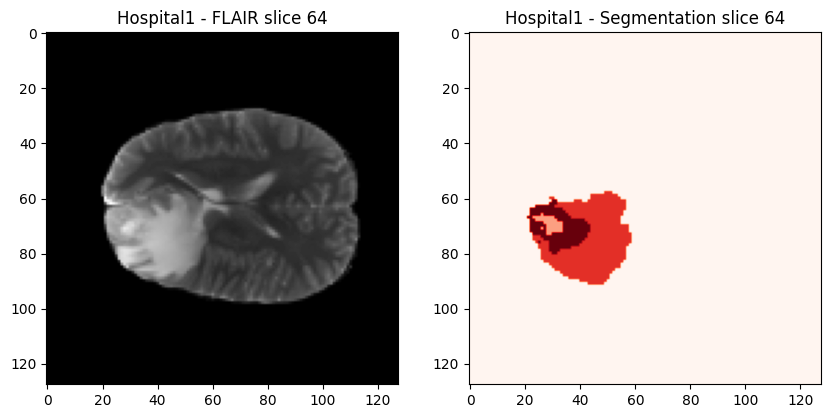

In [7]:
# CELL 5: Visualize Sample Volume + Mask Slice

import random

def visualize_random_sample(hospital="Hospital1", slice_idx=64):
    loader = hospital_loaders[hospital]["train"]
    image, label = next(iter(loader))

    print(f"Input shape: {image.shape} | Label shape: {label.shape}")
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Show slice from FLAIR (assume channel 3)
    axs[0].imshow(image[0, 3, :, :, slice_idx].cpu(), cmap='gray')
    axs[0].set_title(f"{hospital} - FLAIR slice {slice_idx}")

    # Corresponding segmentation mask slice
    axs[1].imshow(label[0, 0, :, :, slice_idx].cpu(), cmap='Reds')
    axs[1].set_title(f"{hospital} - Segmentation slice {slice_idx}")

    plt.show()

# Example call
visualize_random_sample("Hospital1", slice_idx=64)


In [9]:
print("\n📊 Dataset sizes per hospital:")
for hospital, loaders in hospital_loaders.items():
    train_size = len(loaders['train'].dataset)
    val_size = len(loaders['val'].dataset)
    print(f"{hospital} → Train: {train_size} | Val: {val_size}")



📊 Dataset sizes per hospital:
Hospital1 → Train: 1251 | Val: 219
Hospital2 → Train: 1000 | Val: 141
Hospital3 → Train: 165 | Val: 31
Hospital4 → Train: 99 | Val: 45
Hospital5 → Train: 60 | Val: 15
Hospital6 → Train: 1000 | Val: 251
Hospital7 → Train: 369 | Val: 125
Hospital8 → Train: 207 | Val: 52
Hospital9 → Train: 60 | Val: 16


In [10]:
# CELL 7: Fixed TwinSegNet Model (ViT + UNet Hybrid)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class UpBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(UpBlock, self).__init__()
        self.up = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        # Resize skip connection if needed
        if x.shape[2:] != skip.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='trilinear', align_corners=False)
        x = torch.cat((x, skip), dim=1)
        return self.conv(x)


class PatchEmbedViT(nn.Module):
    def __init__(self, in_channels=128, embed_dim=256, patch_size=2):
        super(PatchEmbedViT, self).__init__()
        self.patch_embed = nn.Conv3d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, embed_dim, 1, 1, 1))  # minimal shape

    def forward(self, x):
        x = self.patch_embed(x)
        if x.shape[2:] != self.pos_embed.shape[2:]:
            pos_embed = F.interpolate(self.pos_embed, size=x.shape[2:], mode='trilinear', align_corners=False)
        else:
            pos_embed = self.pos_embed
        return x + pos_embed


class TwinSegNet(nn.Module):
    def __init__(self, in_channels=4, n_classes=3, base_channels=32):
        super(TwinSegNet, self).__init__()

        # Encoder
        self.enc1 = ConvBlock(in_channels, base_channels)              # 128
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ConvBlock(base_channels, base_channels * 2)        # 64
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ConvBlock(base_channels * 2, base_channels * 4)    # 32
        self.pool3 = nn.MaxPool3d(2)
        self.enc4 = ConvBlock(base_channels * 4, base_channels * 8)    # 16
        self.pool4 = nn.MaxPool3d(2)

        # ViT at bottleneck
        self.vit = PatchEmbedViT(in_channels=base_channels * 8, embed_dim=base_channels * 16, patch_size=2)
        self.vit_proj = nn.Conv3d(base_channels * 16, base_channels * 8, kernel_size=1)

        # Decoder (UNet-style)
        self.up4 = UpBlock(base_channels * 8, base_channels * 4, base_channels * 4)  # match enc3
        self.up3 = UpBlock(base_channels * 4, base_channels * 2, base_channels * 2)  # match enc2
        self.up2 = UpBlock(base_channels * 2, base_channels, base_channels)          # match enc1
        self.final_conv = nn.Conv3d(base_channels, n_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)                # [B, 32, 128,128,128]
        e2 = self.enc2(self.pool1(e1))   # [B, 64, 64,64,64]
        e3 = self.enc3(self.pool2(e2))   # [B, 128, 32,32,32]
        e4 = self.enc4(self.pool3(e3))   # [B, 256, 16,16,16]
        b = self.pool4(e4)               # [B, 256, 8,8,8]

        b = self.vit(b)                  # [B, 512, 4,4,4] → [B, 256, 4,4,4]
        b = self.vit_proj(b)             # [B, 256, 4,4,4]

        d4 = self.up4(b, e3)             # [B, 128, 8,8,8]
        d3 = self.up3(d4, e2)            # [B, 64, 16,16,16]
        d2 = self.up2(d3, e1)            # [B, 32, 32,32,32]
        out = self.final_conv(d2)        # [B, n_classes, 32,32,32]

        return out


In [11]:
def dice_loss(pred, target, epsilon=1e-6):
    """
    pred: (B, C, D, H, W)
    target: (B, 1, D', H', W') → label mask
    """
    pred = torch.softmax(pred, dim=1)

    # Resize target to match pred spatial shape
    if target.shape[2:] != pred.shape[2:]:
        target = F.interpolate(target.float(), size=pred.shape[2:], mode='nearest')

    # One-hot encode
    target = target.squeeze(1).long()  # (B, D, H, W)
    target = F.one_hot(target, num_classes=pred.shape[1])  # (B, D, H, W, C)
    target = target.permute(0, 4, 1, 2, 3).float()          # (B, C, D, H, W)

    # Dice computation
    intersection = (pred * target).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    dice = (2 * intersection + epsilon) / (union + epsilon)

    return 1 - dice.mean()


In [12]:
# CELL X: Improved Local Trainer with Logging

def train_one_client(model, dataloader, optimizer, epochs=1, client_name=""):
    model.train()
    model.to(device)
    total_loss = 0

    for epoch in range(epochs):
        epoch_loss = 0
        print(f"\n🚀 [{client_name}] Epoch {epoch+1}/{epochs} — Training {len(dataloader)} patients")

        for i, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            epoch_loss += batch_loss

            print(f"   📦 Batch {i+1}/{len(dataloader)} — Loss: {batch_loss:.4f}")

        avg_loss = epoch_loss / len(dataloader)
        total_loss += avg_loss
        print(f"✅ [{client_name}] Epoch {epoch+1} Complete — Avg Loss: {avg_loss:.4f}")

    return model.state_dict()  # return updated weights for FedAvg


In [13]:
import gc
import torch

def clear_cuda():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    print(f"🧹 GPU memory cleared. Available: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


In [14]:
!nvidia-smi
!fuser -v /dev/nvidia0  # see PIDs using the GPU


Tue Apr 22 17:44:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080        On  |   00000000:21:00.0  On |                  N/A |
|  0%   56C    P8             40W /  320W |     682MiB /  10240MiB |     33%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
!kill -9 <3013>


/bin/bash: -c: line 1: syntax error near unexpected token `3013'
/bin/bash: -c: line 1: `kill -9 <3013>'


In [16]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [17]:
client_devices = {
    "Hospital1": "cuda:0",
    "Hospital2": "cuda:1",
    # add more mappings as needed, alternating between 0 and 1
}


In [18]:
model = TwinSegNet(in_channels=4, n_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

client_name = "Hospital1"
client_loader = hospital_loaders[client_name]["train"]

new_weights = train_one_client(model, client_loader, optimizer, epochs=2, client_name=client_name)



🚀 [Hospital1] Epoch 1/2 — Training 1251 patients
   📦 Batch 1/1251 — Loss: 0.8999
   📦 Batch 2/1251 — Loss: 0.8961
   📦 Batch 3/1251 — Loss: 0.8881
   📦 Batch 4/1251 — Loss: 0.8843
   📦 Batch 5/1251 — Loss: 0.8914
   📦 Batch 6/1251 — Loss: 0.8815
   📦 Batch 7/1251 — Loss: 0.8813
   📦 Batch 8/1251 — Loss: 0.8801
   📦 Batch 9/1251 — Loss: 0.8842
   📦 Batch 10/1251 — Loss: 0.8810
   📦 Batch 11/1251 — Loss: 0.8796
   📦 Batch 12/1251 — Loss: 0.8849
   📦 Batch 13/1251 — Loss: 0.8803
   📦 Batch 14/1251 — Loss: 0.8796
   📦 Batch 15/1251 — Loss: 0.8772
   📦 Batch 16/1251 — Loss: 0.8678
   📦 Batch 17/1251 — Loss: 0.8766
   📦 Batch 18/1251 — Loss: 0.8695
   📦 Batch 19/1251 — Loss: 0.8719
   📦 Batch 20/1251 — Loss: 0.8736
   📦 Batch 21/1251 — Loss: 0.8719
   📦 Batch 22/1251 — Loss: 0.8728
   📦 Batch 23/1251 — Loss: 0.8515
   📦 Batch 24/1251 — Loss: 0.8461
   📦 Batch 25/1251 — Loss: 0.8612
   📦 Batch 26/1251 — Loss: 0.8621
   📦 Batch 27/1251 — Loss: 0.8670
   📦 Batch 28/1251 — Loss: 0.8578
   📦 Ba

In [19]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()


In [20]:

import gc
gc.collect()
torch.cuda.empty_cache()


In [21]:
torch.cuda.memory_summary()


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      | 106091 KiB |   1974 MiB |  17617 GiB |  17617 GiB |\n|       from large pool |  85504 KiB |   1955 MiB |  17531 GiB |  17531 GiB |\n|       from small pool |  20587 KiB |     25 MiB |     86 GiB |     86 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         | 106091 KiB |   1974 MiB |  17617 GiB |  17617 GiB |\n|       from large pool |  85504 KiB |   1955 MiB |